In [26]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [27]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2024-04-05 07:59:32--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.3’

cats_and_dogs.zip.3 100%[===================>]  67.43M   142MB/s    in 0.5s    

2024-04-05 07:59:33 (142 MB/s) - ‘cats_and_dogs.zip.3’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [28]:
# 3

train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0 / 255)
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0 / 255)
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0 / 255)

train_data_gen = train_image_generator.flow_from_directory(directory = train_dir,
                                                           batch_size = batch_size,
                                                           target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode = "binary")
val_data_gen = validation_image_generator.flow_from_directory(directory = validation_dir,
                                                              batch_size = batch_size,
                                                              target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode = "binary")
test_data_gen = test_image_generator.flow_from_directory(directory = PATH,
                                                         batch_size = batch_size,
                                                         target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                         shuffle = False,
                                                         classes=['test'])


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


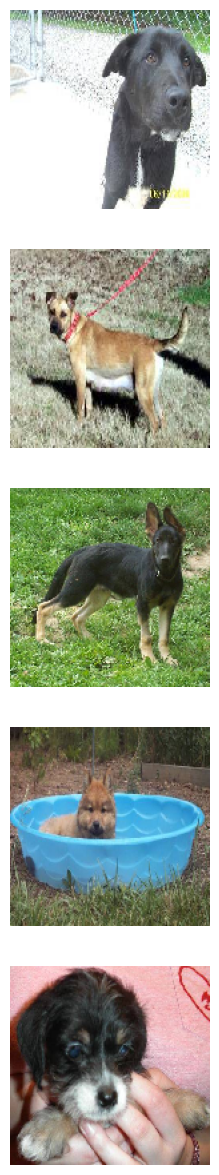

In [29]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [33]:
# 5
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0 / 255,
                                                                        rotation_range=40,
                                                                        zoom_range=0.25,
                                                                        width_shift_range=0.25,
                                                                        height_shift_range=0.25,
                                                                        horizontal_flip=True,
                                                                        fill_mode='nearest')

Found 2000 images belonging to 2 classes.


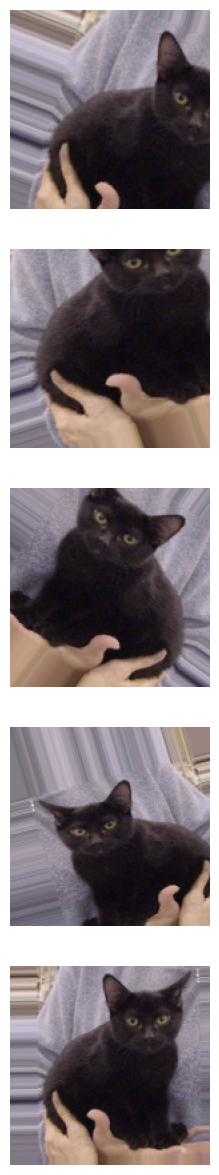

In [34]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [57]:
# 7
#from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D
model = Sequential()

# Convolutions
model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(Conv2D(32, (3,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dense layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Optimizer
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 17, 17, 128)     

In [61]:
#train_steps = int(ceil(1. * total_train / batch_size))
#val_steps   = int(ceil(1. * total_val / batch_size))

#print(train_steps, val_steps)

# 8
history = model.fit(
            train_data_gen, #steps_per_epoch=train_steps,
            validation_data=val_data_gen, #validation_steps=val_steps,
            epochs=epochs)



Epoch 1/15
16/16 [==============================] - 132s 8s/step - loss: 0.7903 - accuracy: 0.5120 - val_loss: 0.6799 - val_accuracy: 0.5280
Epoch 2/15
16/16 [==============================] - 124s 8s/step - loss: 0.6880 - accuracy: 0.5400 - val_loss: 0.6512 - val_accuracy: 0.5980
Epoch 3/15
16/16 [==============================] - 116s 7s/step - loss: 0.6758 - accuracy: 0.5535 - val_loss: 0.6570 - val_accuracy: 0.6120
Epoch 4/15
16/16 [==============================] - 123s 8s/step - loss: 0.6576 - accuracy: 0.5895 - val_loss: 0.6512 - val_accuracy: 0.5970
Epoch 5/15
16/16 [==============================] - 123s 8s/step - loss: 0.6570 - accuracy: 0.5935 - val_loss: 0.6434 - val_accuracy: 0.6220
Epoch 6/15
16/16 [==============================] - 122s 8s/step - loss: 0.6558 - accuracy: 0.5855 - val_loss: 0.6306 - val_accuracy: 0.6350
Epoch 7/15
16/16 [==============================] - 122s 8s/step - loss: 0.6598 - accuracy: 0.5795 - val_loss: 0.6553 - val_accuracy: 0.5570
Epoch 8/15
16

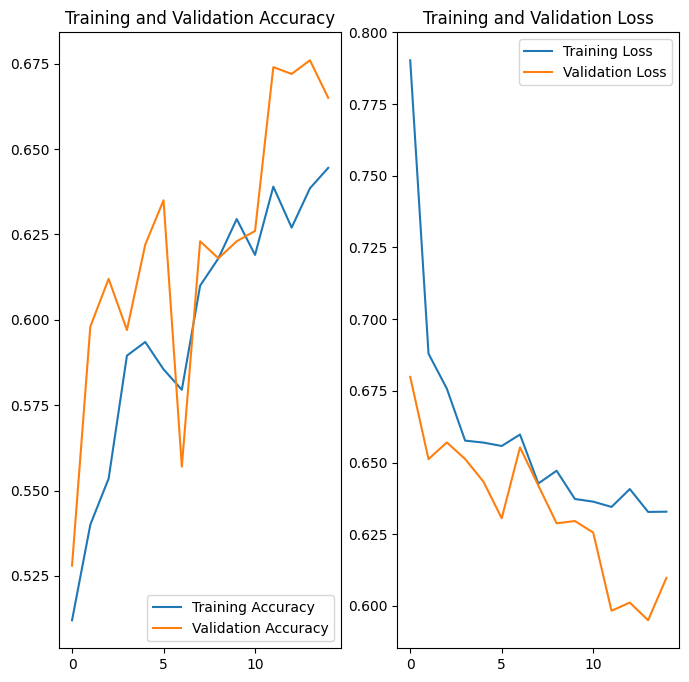

In [62]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 1s 1s/step


<ipython-input-29-e7cffa4c9536>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % (probability*100) + "% dog")
<ipython-input-29-e7cffa4c9536>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % ((1-probability)*100) + "% cat")


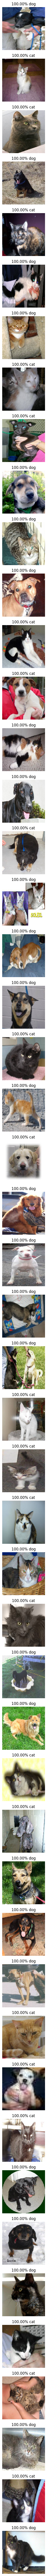

In [63]:
# 10
test_images, _ = next(test_data_gen)
probabilities = (model.predict(test_data_gen) > 0.5).astype("int32")
plotImages(test_images, probabilities=probabilities)

In [64]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if probability == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 68.0% of the images of cats and dogs.
You passed the challenge!
